In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('/content/drive/My Drive/OIL_CrUDE/DCOILWTICO.csv')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
#Use the last available price to fill in missing data (since oil prices don’t change on closed days).
df["observation_date"] = pd.to_datetime(df["observation_date"])

df['DCOILWTICO'] = df['DCOILWTICO'].fillna(method='ffill')
df.head()

,observation_date,DCOILWTICO
0,2015-06-02,61.30
1,2015-06-03,59.67
2,2015-06-04,58.00
3,2015-06-05,59.11
4,2015-06-08,58.15


In [4]:
import pandas as pd
import yfinance as yf

crude = yf.download('CL=F', start='2015-06-02', end='2025-06-02')
crude.reset_index(inplace=True)

crude['Date'] = pd.to_datetime(crude['Date'])

crude.set_index('Date', inplace=True)





YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:

crude = yf.download('CL=F', start='2015-06-02', end='2025-06-02')
crude.reset_index(inplace=True)

crude['Date'] = pd.to_datetime(crude['Date'])
crude.rename(columns={'Date': 'observation_date'}, inplace=True)

if isinstance(crude.columns, pd.MultiIndex):
    crude.columns = crude.columns.get_level_values(0)

df['observation_date'] = pd.to_datetime(df['observation_date'])
df = df.merge(crude[['observation_date', 'Volume']], on='observation_date', how='left')

df['Volume'] = df['Volume'].fillna(method='ffill')

[*********************100%***********************]  1 of 1 completed


In [6]:
!pip install ta

In [7]:
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.utils import dropna

df= dropna(df)

rsi = RSIIndicator(close=df["DCOILWTICO"])
df["RSI"] = rsi.rsi()

macd = MACD(close=df["DCOILWTICO"])
df["MACD"] = macd.macd()
df["MACD_Signal"] = macd.macd_signal()

df["MA10"] = df["DCOILWTICO"].rolling(window=10).mean()
df["MA50"] = df["DCOILWTICO"].rolling(window=50).mean()

bollinger = BollingerBands(close=df["DCOILWTICO"])
df["BB_High"] = bollinger.bollinger_hband()
df["BB_Low"] = bollinger.bollinger_lband()




# CNN

In [11]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

features = [
    'DCOILWTICO', 'Volume', 'MA10', 'RSI', 'MACD'
]

df[features] = df[features].fillna(method='ffill')
df = df.dropna(subset=features)

train = df.iloc[:1950]
valid = df.iloc[1950:2300]
test = df.iloc[2300:]

scaler = MinMaxScaler()

train_data = scaler.fit_transform(train[features])
valid_data = scaler.transform(valid[features])
test_data = scaler.transform(test[features])

print("Train data shape:", train_data.shape)
print("Validation data shape:", valid_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (1950, 5)
Validation data shape: (350, 5)
Test data shape: (283, 5)


In [13]:
def create_sequences(data, seq_length, target_column_idx=None):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        if target_column_idx is None:
            y.append(data[i+seq_length])
        else:
            y.append(data[i+seq_length][target_column_idx])
    return np.array(X), np.array(y)


seq_length = 5
target_col = 0

X_train, y_train = create_sequences(train_data, seq_length, target_col)
X_val, y_val = create_sequences(valid_data, seq_length, target_col)
X_test, y_test = create_sequences(test_data, seq_length, target_col)

print(X_train.shape)
print(y_train.shape)

(1945, 5, 5)
(1945,)


In [20]:
print(X_train.shape)  # (samples, time_steps, features)


(1945, 5, 5)


In [14]:
!pip install optuna

In [21]:
def objective(trial):
    filters1 = trial.suggest_categorical("filters1", [64, 128])
    kernel_size1 = trial.suggest_int("kernel_size1", 1, 3)

    filters2 = trial.suggest_categorical("filters2", [32, 64])
    kernel_size2 = trial.suggest_int("kernel_size2", 1, 3)

    dense_units = trial.suggest_int("dense_units", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    model = Sequential()
    model.add(Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu', padding='same',
                     input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stopping, reduce_lr]
    )

    val_preds = model.predict(X_val)
    return mean_squared_error(y_val, val_preds)


In [22]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("Best trial:")
print(study.best_trial.params)


[I 2025-06-15 13:25:55,849] A new study created in memory with name: no-name-9313de9d-dcf2-4518-80e8-600e8ac9bcb2


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-06-15 13:26:11,618] Trial 0 finished with value: 0.000292940234601245 and parameters: {'filters1': 64, 'kernel_size1': 1, 'filters2': 64, 'kernel_size2': 1, 'dense_units': 113, 'dropout_rate': 0.35130579686891356, 'learning_rate': 0.004423950823573931, 'batch_size': 32}. Best is trial 0 with value: 0.000292940234601245.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-06-15 13:26:26,590] Trial 1 finished with value: 0.0002158173208328221 and parameters: {'filters1': 64, 'kernel_size1': 1, 'filters2': 64, 'kernel_size2': 3, 'dense_units': 50, 'dropout_rate': 0.36558448955694345, 'learning_rate': 0.006951722531154727, 'batch_size': 32}. Best is trial 1 with value: 0.0002158173208328221.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-06-15 13:26:39,986] Trial 2 finished with value: 0.0007798706805983238 and parameters: {'filters1': 128, 'kernel_size1': 2, 'filters2': 32, 'kernel_size2': 1, 'dense_units': 87, 'dropout_rate': 0.48123152083686765, 'learning_rate': 0.00010303800374940363, 'batch_size': 32}. Best is trial 1 with value: 0.0002158173208328221.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[I 2025-06-15 13:26:50,589] Trial 3 finished with value: 0.00026287275866240697 and parameters: {'filters1': 64, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 3, 'dense_units': 38, 'dropout_rate': 0.4493035159548032, 'learning_rate': 0.0005584497932806226, 'batch_size': 32}. Best is trial 1 with value: 0.0002158173208328221.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2025-06-15 13:27:05,050] Trial 4 finished with value: 0.00022417908104514488 and parameters: {'filters1': 64, 'kernel_size1': 1, 'filters2': 32, 'kernel_size2': 3, 'dense_units': 54, 'dropout_rate': 0.4943512498644232, 'learning_rate': 0.004940467234335717, 'batch_size': 32}. Best is trial 1 with value: 0.0002158173208328221.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


[I 2025-06-15 13:27:17,432] Trial 5 finished with value: 0.00016060719070445294 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 3, 'dense_units': 63, 'dropout_rate': 0.32938316854229616, 'learning_rate': 0.0024351792947286915, 'batch_size': 64}. Best is trial 5 with value: 0.00016060719070445294.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


[I 2025-06-15 13:27:29,817] Trial 6 finished with value: 0.0009394924615207067 and parameters: {'filters1': 64, 'kernel_size1': 2, 'filters2': 32, 'kernel_size2': 2, 'dense_units': 63, 'dropout_rate': 0.45829569045164115, 'learning_rate': 0.00016658976949092863, 'batch_size': 64}. Best is trial 5 with value: 0.00016060719070445294.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-06-15 13:27:41,517] Trial 7 finished with value: 0.00045181251040174735 and parameters: {'filters1': 64, 'kernel_size1': 1, 'filters2': 32, 'kernel_size2': 2, 'dense_units': 74, 'dropout_rate': 0.4944664004681755, 'learning_rate': 0.0009165275043331729, 'batch_size': 64}. Best is trial 5 with value: 0.00016060719070445294.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


[I 2025-06-15 13:27:54,571] Trial 8 finished with value: 0.000198426054118884 and parameters: {'filters1': 64, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 3, 'dense_units': 84, 'dropout_rate': 0.45253609086462565, 'learning_rate': 0.0016026058328667172, 'batch_size': 64}. Best is trial 5 with value: 0.00016060719070445294.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


[I 2025-06-15 13:28:05,195] Trial 9 finished with value: 0.00025938692747357224 and parameters: {'filters1': 64, 'kernel_size1': 2, 'filters2': 64, 'kernel_size2': 3, 'dense_units': 91, 'dropout_rate': 0.4742578434541368, 'learning_rate': 0.00039093864088558263, 'batch_size': 64}. Best is trial 5 with value: 0.00016060719070445294.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


[I 2025-06-15 13:28:19,332] Trial 10 finished with value: 0.00017215032526952934 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 124, 'dropout_rate': 0.20050013424529986, 'learning_rate': 0.002512465821778483, 'batch_size': 64}. Best is trial 5 with value: 0.00016060719070445294.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2025-06-15 13:28:28,110] Trial 11 finished with value: 0.00016799996861859557 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 127, 'dropout_rate': 0.20931241481946755, 'learning_rate': 0.0022220635296381266, 'batch_size': 64}. Best is trial 5 with value: 0.00016060719070445294.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


[I 2025-06-15 13:28:41,373] Trial 12 finished with value: 0.00015723934791194986 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 104, 'dropout_rate': 0.21821504204658043, 'learning_rate': 0.00220204709842104, 'batch_size': 64}. Best is trial 12 with value: 0.00015723934791194986.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2025-06-15 13:28:54,706] Trial 13 finished with value: 0.00017933973812710603 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 103, 'dropout_rate': 0.26574224826566123, 'learning_rate': 0.0011806585018974704, 'batch_size': 64}. Best is trial 12 with value: 0.00015723934791194986.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


[I 2025-06-15 13:29:07,552] Trial 14 finished with value: 0.00021413652575182678 and parameters: {'filters1': 128, 'kernel_size1': 2, 'filters2': 64, 'kernel_size2': 1, 'dense_units': 103, 'dropout_rate': 0.2920787593707937, 'learning_rate': 0.0031814124928099, 'batch_size': 64}. Best is trial 12 with value: 0.00015723934791194986.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2025-06-15 13:29:19,322] Trial 15 finished with value: 0.00015617630169909954 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 69, 'dropout_rate': 0.29869641028370175, 'learning_rate': 0.00792768948043337, 'batch_size': 64}. Best is trial 15 with value: 0.00015617630169909954.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


[I 2025-06-15 13:29:32,022] Trial 16 finished with value: 0.00018160783254065217 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 99, 'dropout_rate': 0.24992623556775181, 'learning_rate': 0.00563835486964874, 'batch_size': 64}. Best is trial 15 with value: 0.00015617630169909954.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-06-15 13:29:40,471] Trial 17 finished with value: 0.00017917051934298507 and parameters: {'filters1': 128, 'kernel_size1': 2, 'filters2': 64, 'kernel_size2': 1, 'dense_units': 72, 'dropout_rate': 0.39950487608644203, 'learning_rate': 0.009594005905266215, 'batch_size': 64}. Best is trial 15 with value: 0.00015617630169909954.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-06-15 13:29:52,133] Trial 18 finished with value: 0.0002617194188501948 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 32, 'kernel_size2': 2, 'dense_units': 114, 'dropout_rate': 0.3046010291110481, 'learning_rate': 0.0006811257345635509, 'batch_size': 64}. Best is trial 15 with value: 0.00015617630169909954.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-06-15 13:30:03,802] Trial 19 finished with value: 0.0001486762136409545 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 77, 'dropout_rate': 0.23429945185590811, 'learning_rate': 0.00887466936279092, 'batch_size': 64}. Best is trial 19 with value: 0.0001486762136409545.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-06-15 13:30:17,144] Trial 20 finished with value: 0.00020524658293689932 and parameters: {'filters1': 128, 'kernel_size1': 2, 'filters2': 64, 'kernel_size2': 1, 'dense_units': 36, 'dropout_rate': 0.2481499669890121, 'learning_rate': 0.008466273267897029, 'batch_size': 64}. Best is trial 19 with value: 0.0001486762136409545.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-06-15 13:30:27,846] Trial 21 finished with value: 0.0001488931030825638 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 71, 'dropout_rate': 0.22861597447347137, 'learning_rate': 0.003761606286344957, 'batch_size': 64}. Best is trial 19 with value: 0.0001486762136409545.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-06-15 13:30:36,824] Trial 22 finished with value: 0.0001912431935242975 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 74, 'dropout_rate': 0.2777276669278359, 'learning_rate': 0.004122517544410276, 'batch_size': 64}. Best is trial 19 with value: 0.0001486762136409545.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-06-15 13:30:49,199] Trial 23 finished with value: 0.00017533625449481704 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 59, 'dropout_rate': 0.23407452800528705, 'learning_rate': 0.009707892873109896, 'batch_size': 64}. Best is trial 19 with value: 0.0001486762136409545.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-06-15 13:30:57,751] Trial 24 finished with value: 0.00020835574355341293 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 79, 'dropout_rate': 0.3181250629488636, 'learning_rate': 0.006486396831333566, 'batch_size': 64}. Best is trial 19 with value: 0.0001486762136409545.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-06-15 13:31:08,272] Trial 25 finished with value: 0.00015746474570095819 and parameters: {'filters1': 128, 'kernel_size1': 2, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 46, 'dropout_rate': 0.27191128830248007, 'learning_rate': 0.0037209204661033824, 'batch_size': 64}. Best is trial 19 with value: 0.0001486762136409545.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[I 2025-06-15 13:31:22,083] Trial 26 finished with value: 0.00016717116153741582 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 32, 'kernel_size2': 1, 'dense_units': 68, 'dropout_rate': 0.23492106317545552, 'learning_rate': 0.005944667472244711, 'batch_size': 32}. Best is trial 19 with value: 0.0001486762136409545.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-06-15 13:31:33,034] Trial 27 finished with value: 0.00020872805544673397 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 80, 'dropout_rate': 0.2931738074661827, 'learning_rate': 0.0015779131710885182, 'batch_size': 64}. Best is trial 19 with value: 0.0001486762136409545.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-06-15 13:31:43,075] Trial 28 finished with value: 0.0001788143715128727 and parameters: {'filters1': 128, 'kernel_size1': 2, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 93, 'dropout_rate': 0.40427415589546434, 'learning_rate': 0.0031513005270303045, 'batch_size': 64}. Best is trial 19 with value: 0.0001486762136409545.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-06-15 13:31:57,279] Trial 29 finished with value: 0.00017951128687688947 and parameters: {'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 1, 'dense_units': 67, 'dropout_rate': 0.22676893466145318, 'learning_rate': 0.004679238390270299, 'batch_size': 32}. Best is trial 19 with value: 0.0001486762136409545.


Best trial:
{'filters1': 128, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 2, 'dense_units': 77, 'dropout_rate': 0.23429945185590811, 'learning_rate': 0.00887466936279092, 'batch_size': 64}


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same',
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(77, activation='relu'))
model.add(Dropout(0.2343))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.00887466936279092)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

model.compile(optimizer=optimizer, loss='mse')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0617 - val_loss: 3.0424e-04 - learning_rate: 0.0089
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0065 - val_loss: 0.0021 - learning_rate: 0.0089
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_loss: 0.0023 - learning_rate: 0.0089
Epoch 4/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004437334835529327.
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 5.0215e-04 - learning_rate: 0.0089
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - val_loss: 2.7585e-04 - learning_rate: 0.0044
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 7.2945e-04 - learning_rate: 0.0044
Epoch 7/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0022186674177646637.
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 -

In [24]:
train_predict = model.predict(X_train)
Val_predict = model.predict(X_val)
test_predict=model.predict(X_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from math import sqrt

# -------- sMAPE Function --------
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# -------- MASE Function --------
def mase(y_true, y_pred):
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    return mae_model / mae_naive

# ----------- Train Metrics -----------
train_rmse = sqrt(mean_squared_error(y_train, train_predict))
train_mse = mean_squared_error(y_train, train_predict)
train_mae = mean_absolute_error(y_train, train_predict)
train_smape = smape(y_train, train_predict)
train_mase = mase(y_train, train_predict)
train_r2 = r2_score(y_train, train_predict)

# ----------- Validation Metrics -----------
val_rmse = sqrt(mean_squared_error(y_val, Val_predict))
val_mse = mean_squared_error(y_val, Val_predict)
val_mae = mean_absolute_error(y_val, Val_predict)
val_smape = smape(y_val, Val_predict)
val_mase = mase(y_val, Val_predict)
val_r2 = r2_score(y_val, Val_predict)

# ----------- Test Metrics -----------
test_rmse = sqrt(mean_squared_error(y_test, test_predict))
test_mse = mean_squared_error(y_test, test_predict)
test_mae = mean_absolute_error(y_test, test_predict)
test_smape = smape(y_test, test_predict)
test_mase = mase(y_test, test_predict)
test_r2 = r2_score(y_test, test_predict)

# ---------- Print All ----------
print("======== Train Metrics ========")
print(f"Train RMSE: {train_rmse}")
print(f"Train MSE: {train_mse}")
print(f"Train MAE: {train_mae}")
print(f"Train sMAPE: {train_smape:.2f}%")
print(f"Train MASE: {train_mase:.3f}")
print(f"Train R² Score: {train_r2:.4f}")

print("\n======== Validation Metrics ========")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MSE: {val_mse}")
print(f"Validation MAE: {val_mae}")
print(f"Validation sMAPE: {val_smape:.2f}%")
print(f"Validation MASE: {val_mase:.3f}")
print(f"Validation R² Score: {val_r2:.4f}")

print("\n======== Test Metrics ========")
print(f"Test RMSE: {test_rmse}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test sMAPE: {test_smape:.2f}%")
print(f"Test MASE: {test_mase:.3f}")
print(f"Test R² Score: {test_r2:.4f}")


======== Train Metrics ========
Train RMSE: 0.017613178511907364
Train MSE: 0.00031022405729231526
Train MAE: 0.010767255688230847
Train sMAPE: 20.75%
Train MASE: 18.273
Train R² Score: 0.9780

======== Validation Metrics ========
Validation RMSE: 0.013294962682448837
Validation MSE: 0.00017675603272770718
Validation MAE: 0.010543324135521809
Validation sMAPE: 5.52%
Validation MASE: 5.393
Validation R² Score: 0.8636

======== Test Metrics ========
Test RMSE: 0.012150133148054113
Test MSE: 0.00014762573551544336
Test MAE: 0.009180678390349237
Test sMAPE: 6.27%
Test MASE: 6.418
Test R² Score: 0.9025


In [30]:
model.save("CNN.h5")


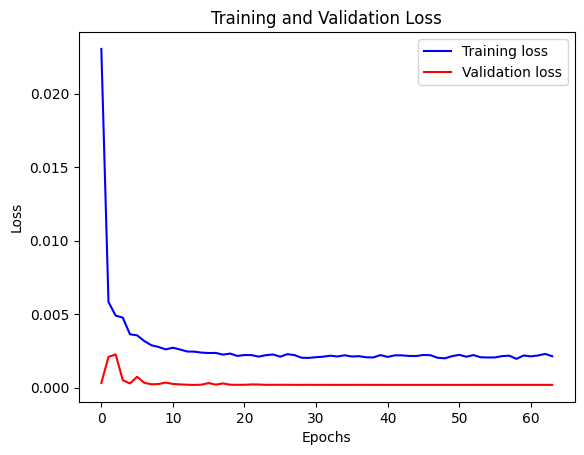

In [26]:
import matplotlib.pyplot as plt

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")



In [27]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


target_col = 0

scaler_y = MinMaxScaler()
scaler_y.fit(train_data[:, target_col].reshape(-1, 1))

y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))

train_predict_inv = scaler_y.inverse_transform(train_predict)
y_train_inv = scaler_y.inverse_transform(y_train.reshape(-1, 1))

val_predict_inv = scaler_y.inverse_transform(Val_predict)
y_val_inv = scaler_y.inverse_transform(y_val.reshape(-1, 1))


y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))



test_predict_inv = scaler_y.inverse_transform(test_predict)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))


Train dates vs y_train_inv: 1945 1945
Val dates vs y_val_inv: 345 345
Test dates vs y_test_inv: 278 278


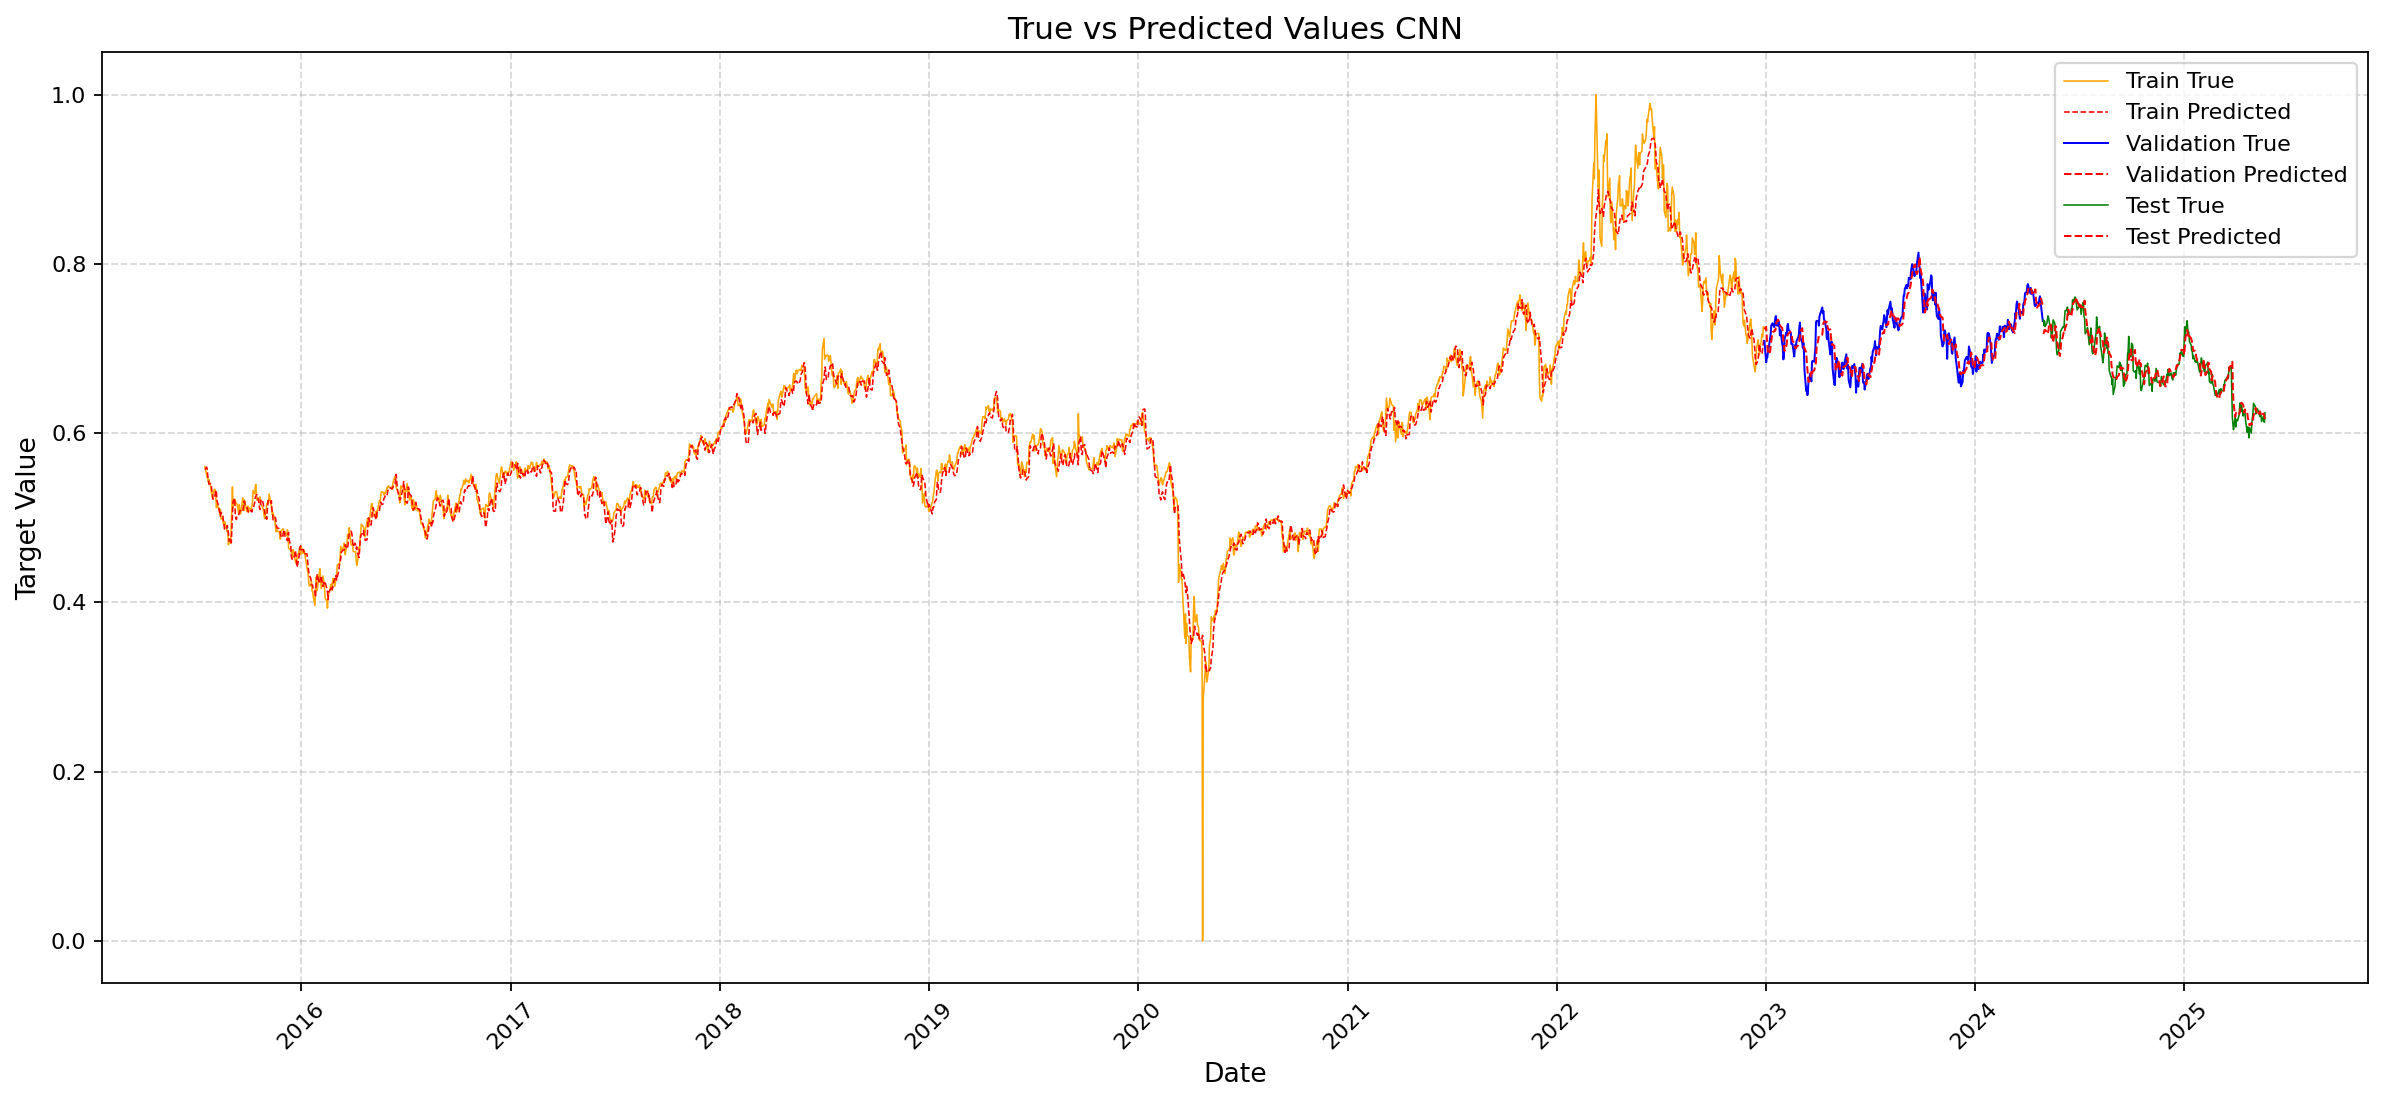

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df['observation_date'] = pd.to_datetime(df['observation_date'])

seq_length = 8

train_len = len(y_train_inv)
val_len = len(y_val_inv)
test_len = len(y_test_inv)

total_y = train_len + val_len + test_len

adjusted_dates = df['observation_date'].values[seq_length: seq_length + total_y]

train_dates = adjusted_dates[:train_len]
val_dates = adjusted_dates[train_len:train_len + val_len]
test_dates = adjusted_dates[train_len + val_len:]

print("Train dates vs y_train_inv:", len(train_dates), len(y_train_inv))
print("Val dates vs y_val_inv:", len(val_dates), len(y_val_inv))
print("Test dates vs y_test_inv:", len(test_dates), len(y_test_inv))

y_train_inv = y_train_inv.flatten()
train_predict_inv = train_predict_inv.flatten()
y_val_inv = y_val_inv.flatten()
val_predict_inv = val_predict_inv.flatten()
y_test_inv = y_test_inv.flatten()
test_predict_inv = test_predict_inv.flatten()

plt.figure(figsize=(15, 7), dpi=160)

plt.plot(train_dates, y_train_inv, label='Train True', color='orange', linewidth=0.7)
plt.plot(train_dates, train_predict_inv, label='Train Predicted', linestyle='--', color='red', linewidth=0.7)

plt.plot(val_dates, y_val_inv, label='Validation True', color='blue', linewidth=0.9)
plt.plot(val_dates, val_predict_inv, label='Validation Predicted', linestyle='--', color='red', linewidth=0.9)

plt.plot(test_dates, y_test_inv, label='Test True', color='green', linewidth=0.7)
plt.plot(test_dates, test_predict_inv, label='Test Predicted', linestyle='--', color='red', linewidth=0.9)

plt.title('True vs Predicted Values CNN', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
